In [86]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import matplotlib.pyplot as plt
import glob # Can be useful but we use os

In [87]:
SIZE = 300
BATCH_SIZE = 32
CHANNELS = 1
PATCH_SIZE = 32
N_PATCHES = (SIZE // PATCH_SIZE) ** 2
PATCH_DIM = (PATCH_SIZE ** 2) * CHANNELS
INPUT_SHAPE = (N_PATCHES, PATCH_DIM)
GENDER_FEATURE_SHAPE = (1,)
EPOCHS = 50
LEARNING_RATE = 4e-4

In [88]:
base_dir = '.'

train_csv_path = os.path.join(base_dir, 'Train', 'train_labels.csv')
val_csv_path = os.path.join(base_dir, 'Val', 'val_labels.csv')
test_csv_path = os.path.join(base_dir, 'Test', 'test_labels.csv')

train_image_dir = os.path.join(base_dir, 'Train', 'train_samples_pp')
val_image_dir = os.path.join(base_dir, 'Val', 'val_samples_pp')
test_image_dir = os.path.join(base_dir, 'Test', 'test_samples_pp')

checkpoint_filepath = 'Models/gender_model.keras'

def load_labels(csv_path):
    df = pd.read_csv(csv_path, index_col='id')
    df = df[['boneage', 'male']].rename(columns={'male': 'gender'})
    df['gender'] = df['gender'].astype(np.float32)
    df['boneage'] = df['boneage'].astype(np.float32)
    return df

In [89]:
def create_dataframe(image_dir, labels_df):
    data = []

    for filename in os.listdir(image_dir):
        file_id = int(filename.split('.')[0])
        if file_id in labels_df.index:
            boneage = labels_df.loc[file_id, 'boneage']
            gender = labels_df.loc[file_id, 'gender']
            full_path = os.path.join(image_dir, filename)
            data.append({'file_path': full_path, 'boneage': boneage, 'gender': gender})

    return pd.DataFrame(data)


def preprocess_image(image, labels):
    image = tf.image.resize(image, [SIZE, SIZE])
    if image.shape[-1] is None:
        image = tf.reshape(image, [SIZE, SIZE, CHANNELS])
    elif image.shape[-1] != CHANNELS:
        image = tf.image.rgb_to_grayscale(image)

    image = tf.cast(image, tf.float32) / 255.0

    patches = tf.image.extract_patches(
        images=tf.expand_dims(image, 0),
        sizes=[1, PATCH_SIZE, PATCH_SIZE, 1],
        strides=[1, PATCH_SIZE, PATCH_SIZE, 1],
        rates=[1, 1, 1, 1],
        padding='VALID',
    )
    patches = tf.reshape(patches, (1, N_PATCHES, PATCH_DIM))
    patches = tf.squeeze(patches, axis=0)

    return patches, labels


def image_label_generator(file_paths, boneage_labels, gender_labels):
    for path, boneage, gender in zip(file_paths, boneage_labels, gender_labels):
        img_bytes = tf.io.read_file(path)
        image = tf.io.decode_image(img_bytes, channels=CHANNELS, expand_animations=False)
        image.set_shape([None, None, CHANNELS])
        yield image, (boneage, gender)


def create_tf_dataset(dataframe, shuffle, repeat_flag, batch_size_local=BATCH_SIZE):
    dataset = tf.data.Dataset.from_generator(
        image_label_generator,
        args=[
            dataframe['file_path'].values,
            dataframe['boneage'].values,
            dataframe['gender'].values],
        output_signature=(
            tf.TensorSpec(shape=(None, None, CHANNELS), dtype=tf.uint8),
            (tf.TensorSpec(shape=(), dtype=tf.float32), tf.TensorSpec(shape=(), dtype=tf.float32))))

    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.map(lambda img, labels: ((img, labels[1]), labels[0]),
                          num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe), reshuffle_each_iteration=True)

    if repeat_flag:
        dataset = dataset.repeat()

    dataset = dataset.batch(batch_size_local)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [90]:
train_labels_df = load_labels(train_csv_path)
val_labels_df = load_labels(val_csv_path)
test_labels_df = load_labels(test_csv_path)

training_dataframe = create_dataframe(train_image_dir, train_labels_df)
validation_dataframe = create_dataframe(val_image_dir, val_labels_df)
test_dataframe = create_dataframe(test_image_dir, test_labels_df)

train_dataset = create_tf_dataset(training_dataframe, shuffle=True, repeat_flag=True)
validation_dataset = create_tf_dataset(validation_dataframe, shuffle=False, repeat_flag=True)
test_dataset_eval = create_tf_dataset(test_dataframe, shuffle=False, repeat_flag=False)

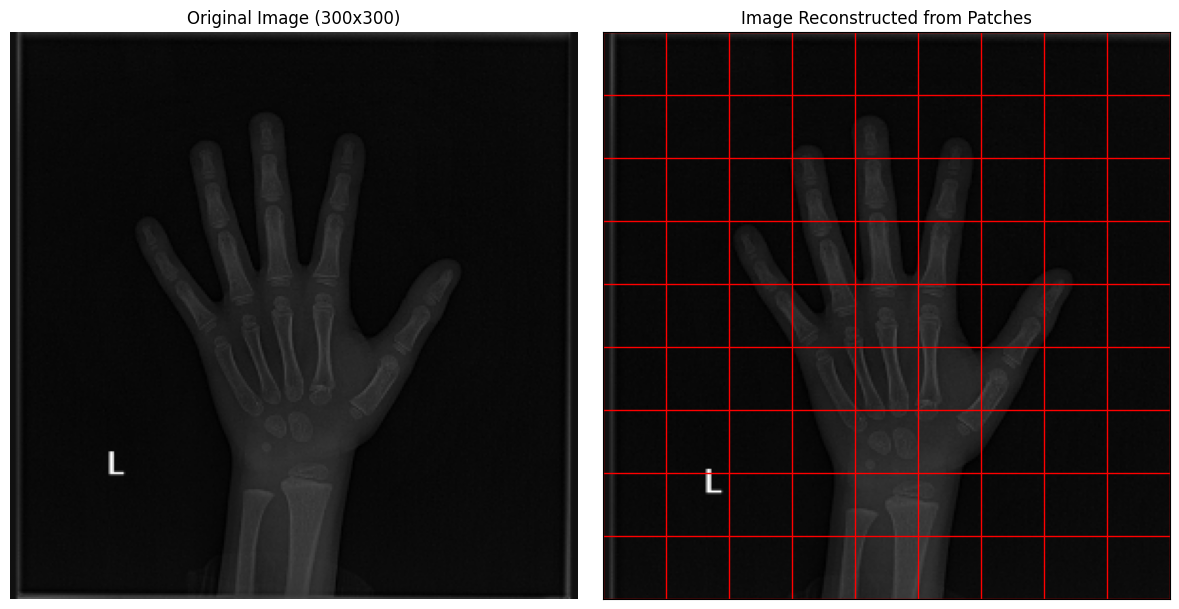

In [91]:
sample_row = test_dataframe.iloc[3]
image_path = sample_row['file_path']
img_bytes = tf.io.read_file(image_path)
image = tf.io.decode_image(img_bytes, channels=CHANNELS, expand_animations=False)
image_resized = tf.image.resize(image, [SIZE, SIZE])
image_resized_float = tf.cast(image_resized, tf.float32) / 255.0

patches_tensor = tf.image.extract_patches(
images=tf.expand_dims(image_resized_float, 0),
sizes=[1, PATCH_SIZE, PATCH_SIZE, 1],
strides=[1, PATCH_SIZE, PATCH_SIZE, 1],
rates=[1, 1, 1, 1],
padding='VALID',
)

num_patches_per_side = SIZE // PATCH_SIZE
patches_reshaped = tf.reshape(patches_tensor, [num_patches_per_side, num_patches_per_side, PATCH_SIZE, PATCH_SIZE, CHANNELS])
patches_np = patches_reshaped.numpy()

rows = []
for i in range(num_patches_per_side):
    row = np.concatenate(patches_np[i, :, :, :, :], axis=1)
    rows.append(row)
    patch_grid_image = np.concatenate(rows, axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(image_resized_float.numpy().squeeze(), cmap='gray')
ax1.set_title(f'Original Image ({SIZE}x{SIZE})')
ax1.axis('off')

ax2.imshow(patch_grid_image.squeeze(), cmap='gray')
ax2.set_title(f'Image Reconstructed from Patches')
ax2.grid(True, which='both', color='red', linestyle='-', linewidth=1)
ax2.set_xticks(np.arange(-.5, SIZE, PATCH_SIZE))
ax2.set_yticks(np.arange(-.5, SIZE, PATCH_SIZE))
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.tick_params(length=0)

plt.tight_layout()
plt.show()

In [92]:
def gender_model(input_shape, gender_shape):

    image_input = keras.Input(shape=input_shape, name="image_input")
    gender_input = keras.Input(shape=gender_shape, name="gender_input")

    x = layers.Dense(128, activation="relu", name='patch_embedding')(image_input)

    x = layers.Bidirectional(layers.GRU(256, return_sequences=True, name='gru1', dropout=0.3, recurrent_dropout=0.3))(x)
    x = layers.BatchNormalization(name='bn_gru1')(x)

    x = layers.Bidirectional(layers.GRU(256, return_sequences=True, name='gru2', dropout=0.3, recurrent_dropout=0.3))(x)
    x = layers.BatchNormalization(name='bn_gru2')(x)

    x = layers.Bidirectional(layers.GRU(128, return_sequences=False, name='gru3', dropout=0.3, recurrent_dropout=0.3))(x)
    x = layers.BatchNormalization(name='bn_gru3')(x)

    image_features = x

    concatenated_features = layers.concatenate([image_features, gender_input],
                                               name='concatenate_features')

    x = layers.Dense(256, name='dense_head1')(concatenated_features)
    x = layers.BatchNormalization(name='bn_head1')(x)
    x = layers.Activation('relu', name='relu_head1')(x)
    x = layers.Dropout(0.5, name='dropout_head1')(x)

    x = layers.Dense(128, name='dense_head2')(x)
    x = layers.BatchNormalization(name='bn_head2')(x)
    x = layers.Activation('relu', name='relu_head2')(x)
    x = layers.Dropout(0.5, name='dropout_head2')(x)

    bone_age_output = layers.Dense(1, activation='linear', name='bone_age_output')(x)

    model = keras.Model(
        inputs=[image_input, gender_input],
        outputs=bone_age_output,
        name="bone_age_predictor")

    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mae'])

    return model


model = gender_model(INPUT_SHAPE, GENDER_FEATURE_SHAPE)
model.summary()

Model: "bone_age_predictor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 81, 1024)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_embedding     │ (None, 81, 128)   │    131,200 │ image_input[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_14    │ (None, 81, 512)   │    592,896 │ patch_embedding[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_gru1             │ (None, 81, 512)   │      2,048 │ bidirectional_14… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_15    │ (None, 81, 512)   │  1,182,720 │ bn_gru1[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_gru2             │ (None, 81, 512)   │      2,048 │ bidirectional_15… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_16    │ (None, 256)       │    493,056 │ bn_gru2[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_gru3             │ (None, 256)       │      1,024 │ bidirectional_16… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_input        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_featur… │ (None, 257)       │          0 │ bn_gru3[0][0],    │
│ (Concatenate)       │                   │            │ gender_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_head1 (Dense) │ (None, 256)       │     66,048 │ concatenate_feat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_head1            │ (None, 256)       │      1,024 │ dense_head1[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu_head1          │ (None, 256)       │          0 │ bn_head1[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_head1       │ (None, 256)       │          0 │ relu_head1[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_head2 (Dense) │ (None, 128)       │     32,896 │ dropout_head1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_head2            │ (None, 128)       │        512 │ dense_head2[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu_head2          │ (None, 128)       │          0 │ bn_head2[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,505,601 (9.56 MB)

 Trainable params: 2,502,273 (9.55 MB)

 Non-trainable params: 3,328 (13.00 KB)

In [93]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_mae', # save the best mae
    mode='min',
    save_best_only=True)

early_stopping_callback = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    mode='min',
    restore_best_weights=True)
# restore best weights because it tends to overfit
# monitor loss because it's the actual improvement metric meanwhile mae can be a face value metric

reduce_lr_callback = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    mode='min',
    min_lr=1e-6)
# trial and error came to a best hyperparam of 3 epochs

callback_list = [model_checkpoint_callback, early_stopping_callback, reduce_lr_callback]

steps = len(training_dataframe) // BATCH_SIZE
val_steps = len(validation_dataframe) // BATCH_SIZE

In [94]:
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=steps,
    validation_data=validation_dataset,
    validation_steps=val_steps,
    callbacks=callback_list)
best_model = keras.models.load_model(checkpoint_filepath)


Epoch 1/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 337s 742ms/step - loss: 17084.0547 - mae: 123.8972 - val_loss: 16040.3008 - val_mae: 119.6872 - learning_rate: 4.0000e-04
Epoch 2/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 274s 728ms/step - loss: 14365.4727 - mae: 112.4678 - val_loss: 12170.0771 - val_mae: 102.5285 - learning_rate: 4.0000e-04
Epoch 3/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 269s 716ms/step - loss: 10009.9834 - mae: 91.7373 - val_loss: 6546.5015 - val_mae: 71.8135 - learning_rate: 4.0000e-04
Epoch 4/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 240s 639ms/step - loss: 5680.8633 - mae: 66.0572 - val_loss: 3419.3020 - val_mae: 50.1003 - learning_rate: 4.0000e-04
Epoch 5/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 218s 579ms/step - loss: 3080.0183 - mae: 47.1744 - val_loss: 2093.3198 - val_mae: 38.7752 - learning_rate: 4.0000e-04
Epoch 6/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 217s 576ms/step - loss: 2130.6096 - mae: 38.4966 - val_loss: 1738.9897 - val_mae: 34.6392 - learning_rate: 4.0000e-04
Epoch 7/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 215

In [95]:
test_results = best_model.evaluate(test_dataset_eval, verbose=1, steps=1)
test_results

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 2445.2690 - mae: 37.7206


[2445.26904296875, 37.72062683105469]

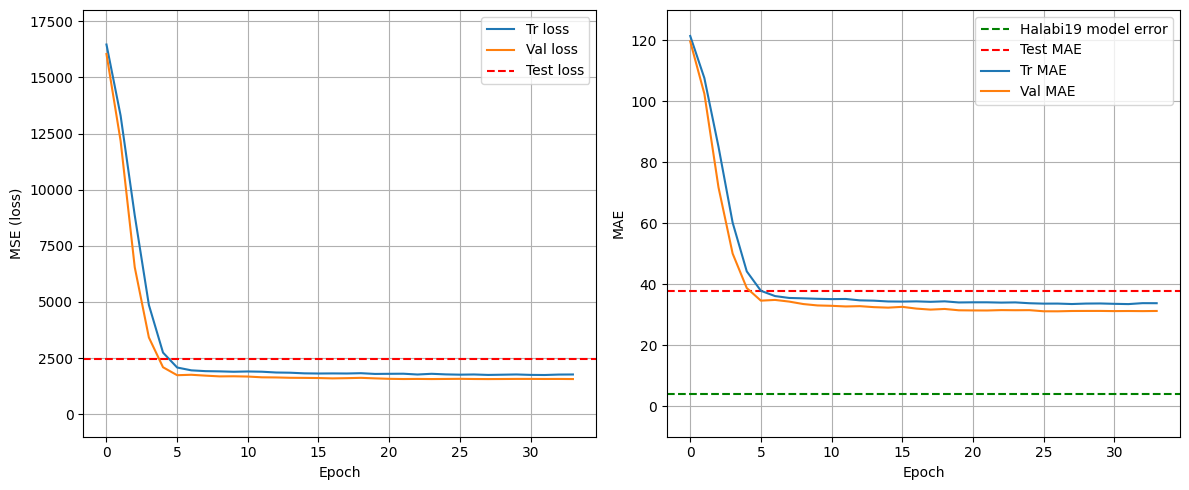

In [96]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.ylim(-1000, 18000)
plt.plot(history.history['loss'], label='Tr loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.axhline(y=test_results[0], color='r', linestyle='--', label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('MSE (loss)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.ylim(-10, 130)
plt.axhline(y=4, color='g', linestyle='--', label='Halabi19 model error')
plt.axhline(y=test_results[1], color='r', linestyle='--', label='Test MAE')
plt.plot(history.history['mae'], label='Tr MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()